In [ ]:
import sqlite3
import pandas as pd

def print_table(query, p=False):
    conn = sqlite3.connect('../data/ratingRager.db')
    cursor = conn.cursor()
    cursor.execute(query)

    column_names = [description[0] for description in cursor.description]

    rows = cursor.fetchall()

    column_widths = [max(len(str(row[i])) for row in rows + [column_names]) for i in range(len(column_names))]

    header = "  ".join(f"{name:<{column_widths[i]}}" for i, name in enumerate(column_names))
    if p:
        print('\n',header)
        print("-" * len(header))

        for row in rows:
            row_str = "  ".join(f"{str(item):<{column_widths[i]}}" for i, item in enumerate(row))
            print(row_str)
        print('\n')

    return pd.read_sql_query(query, conn)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
QUERY = """
    SELECT * FROM restaurants;
"""
df = print_table(QUERY)

In [ ]:
features = df[["latitude", "longitude", "rating", "price_level", "rating_volume"]]
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [ ]:
import numpy as np
print(np.isnan(normalized_features).sum())


1853


In [ ]:
# Replace NaNs with column means

col_mean = np.nanmean(normalized_features, axis=0)
indices = np.where(np.isnan(normalized_features))
normalized_features[indices] = np.take(col_mean, indices[1])

In [ ]:
print(np.isnan(normalized_features).sum())

0


In [ ]:
from sklearn.metrics import silhouette_score

best_eps = 0.0
best_min_samples = 0
best_score = -1

# Find the Optimal eps and min_samples combination

for eps in np.arange(0.1, 5.0, 0.1):
    for min_samples in range(2, 100):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(normalized_features)
        if len(set(clusters)) > 1:
            score = silhouette_score(normalized_features, clusters)
            if score > best_score:
                best_eps, best_min_samples, best_score = eps, min_samples, score

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Silhouette Score: {best_score}")


Best eps: 2.8000000000000003, Best min_samples: 2, Silhouette Score: 0.8380653494346839


In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)  # Adjust eps and min_samples based on data
clusters = dbscan.fit_predict(normalized_features)
df["cluster"] = clusters

In [ ]:
# Calculate Cluster Sentiment
cluster_sentiment = df.groupby("cluster")["rating"].mean().reset_index()
cluster_sentiment.columns = ["cluster", "location_sentiment"]
df = df.merge(cluster_sentiment, on="cluster", how="left")

In [ ]:
print(df["location_sentiment"].min())
print(df["location_sentiment"].max())

4.170177664974619
4.199999999999999


In [ ]:
# Data looks odd, so trying with only location and rating for cluster
df["cluster_sentiment"] = df["location_sentiment"]

In [ ]:
features = df[["latitude", "longitude", "rating"]]
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [ ]:
import numpy as np
print(np.isnan(normalized_features).sum())


0


In [ ]:
from sklearn.metrics import silhouette_score

best_eps = 0.0
best_min_samples = 0
best_score = -1

# Find the Optimal eps and min_samples combination
for eps in np.arange(0.01, 0.5, 0.005):
    for min_samples in range(3, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(normalized_features)
        if len(set(clusters)) > 1:
            score = silhouette_score(normalized_features, clusters)
            if score > best_score:
                best_eps, best_min_samples, best_score = eps, min_samples, score

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Silhouette Score: {best_score}")


Best eps: 0.48999999999999994, Best min_samples: 7, Silhouette Score: 0.4395122235975267


In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)  # Adjust eps and min_samples based on data
clusters = dbscan.fit_predict(normalized_features)
df["cluster"] = clusters

In [ ]:
# Calculate Cluster Sentiment
cluster_sentiment = df.groupby("cluster")["rating"].mean().reset_index()
cluster_sentiment.columns = ["cluster", "l_score"]
df = df.merge(cluster_sentiment, on="cluster", how="left")

In [ ]:
print(cluster_sentiment.keys())
print(df.keys())

Index(['cluster', 'l_score'], dtype='object')
Index(['id', 'name', 'rating', 'rating_volume', 'address', 'latitude',
       'longitude', 'price_level', 'cluster', 'location_sentiment_x',
       'cluster_sentiment', 'location_sentiment_y', 'l_sentiment_x',
       'l_sentiment_y', 'l_score'],
      dtype='object')


In [ ]:
print(df['l_score'].max())
print(df['l_score'].min())

4.230911005792523
2.5687499999999996


In [ ]:
# Normalize to number between 0 and 1
df['l_score'] = df['l_score'] / 5

In [ ]:
print(df['l_score'].max())
print(df['l_score'].min())
print(df['l_score'])

0.8461822011585045
0.5137499999999999
0       0.846182
1       0.846182
2       0.846182
3       0.513750
4       0.846182
          ...   
3937    0.846182
3938    0.846182
3939    0.846182
3940    0.846182
3941    0.846182
Name: l_score, Length: 3942, dtype: float64


In [ ]:
# Update score table

conn = sqlite3.connect('../data/ratingRager.db')
cursor = conn.cursor()

for index, row in df.iterrows():
    cursor.execute(
        "UPDATE scores SET location_score = ? WHERE restaurant_id = ?;",
        (row['l_sentiment'], row['id'])
    )

conn.commit()
conn.close()

### Retrying Location Sentiment with K Means (Poor Scores)

In [ ]:
 import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

QUERY = """
    SELECT * FROM restaurants;
"""
df = print_table(QUERY)

In [ ]:
features = df[['latitude', 'longitude']].copy()

scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

In [ ]:
y = df['rating']

knn = KNeighborsRegressor(n_neighbors=5, weights='distance')

knn.fit(normalized_features, y)

df['location_sentiment'] = knn.predict(normalized_features)

print(df[['name', 'location_sentiment']])


                                                   name  location_sentiment
0                                                Subway                 4.2
1                                            Ruby Queen                 4.0
2                                   Kinjo Sushi & Grill                 4.3
3                                           Tim Hortons                 2.3
4                             Popeyes Louisiana Kitchen                 4.4
...                                                 ...                 ...
3937  Hankook Chicken (Korean Fried chicken & Rice b...                 4.8
3938                                       Saigon Maxim                 4.4
3939                                         Carl's Jr.                 4.1
3940                              Ken's Kowloon Kitchen                 4.3
3941                                    Edgemont Palace                 3.6

[3942 rows x 2 columns]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

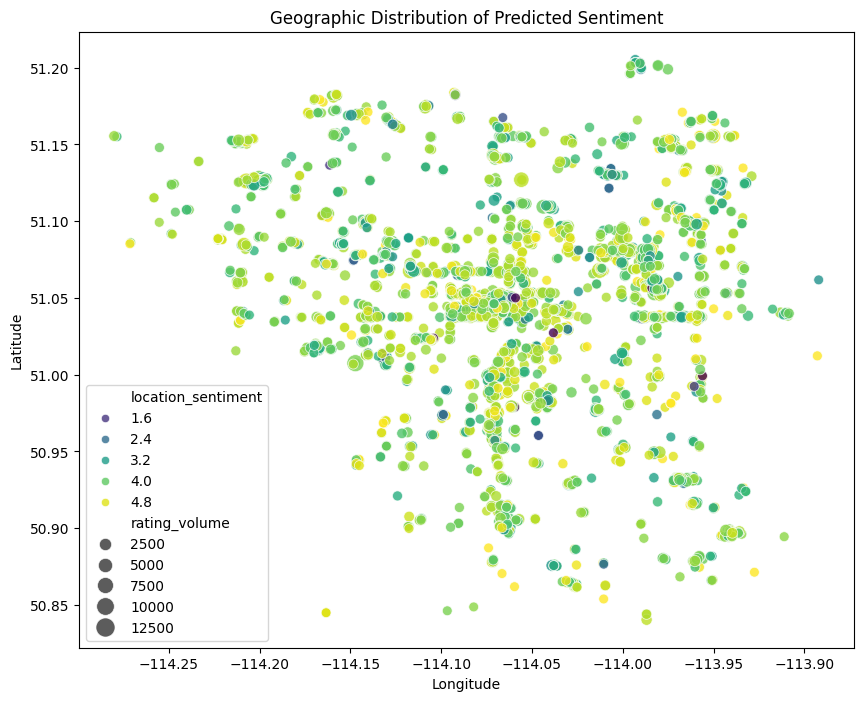

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'latitude', 'longitude', and 'predicted_sentiment' are in the DataFrame
plt.figure(figsize=(10, 8))

# Scatterplot with color-coded sentiment
sns.scatterplot(
    x=df['longitude'],
    y=df['latitude'],
    hue=df['location_sentiment'],
    palette='viridis',
    size=df['rating_volume'],  # Optional: Scale points by review volume
    sizes=(50, 200),
    alpha=0.8
)

plt.title('Geographic Distribution of Predicted Sentiment')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Predicted Sentiment')
plt.show()

In [ ]:
import folium

m = folium.Map(location=[51.0447, -114.0719], zoom_start=12)  # Coords for Calgary

# Add restaurants as points
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=folium.Popup(f"Name: {row['name']}<br>Location Sentiment: {row['location_sentiment']:.2f}", max_width=200),
    ).add_to(m)

# Display the map
m.save('map.html')
m


In [ ]:
print(df.keys())

Index(['id', 'name', 'rating', 'rating_volume', 'address', 'latitude',
       'longitude', 'price_level', 'location_sentiment'],
      dtype='object')


In [ ]:
df['location_score'] = df['location_sentiment'] / 5

print(df['location_score'])

0       0.84
1       0.80
2       0.86
3       0.46
4       0.88
        ... 
3937    0.96
3938    0.88
3939    0.82
3940    0.86
3941    0.72
Name: location_score, Length: 3942, dtype: float64


In [ ]:
print(df.keys())

Index(['id', 'name', 'rating', 'rating_volume', 'address', 'latitude',
       'longitude', 'price_level', 'location_sentiment', 'location_score'],
      dtype='object')


In [ ]:
# Update score table

conn = sqlite3.connect('../data/ratingRager.db')
cursor = conn.cursor()

for index, row in df.iterrows():
    cursor.execute(
        "UPDATE scores SET location_score = ? WHERE restaurant_id = ?;",
        (row['location_score'], row['id'])
    )

conn.commit()
conn.close()